In [1]:
# Instalación de dependencias
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install easyocr
!pip install yolov5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar librerías necesarias
import torch #Biblioteca para trabajar con modelos de aprendizaje profundo
import cv2 # Biblioteca para procesamiento de imágenes y video
import time # Para medir tiempos de ejecución
import re # Biblioteca para trabajar con expresiones regulares
import numpy as np # Biblioteca para cálculos numéricos
import easyocr # Biblioteca OCR para reconocimiento de texto
import os # Biblioteca para manejo de archivos y directorios
from IPython.display import Image, display # Para mostrar imágenes en Jupyter Notebook
import yolov5 # Biblioteca YOLOv5 para detección de objetos

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Definir variables globales
EASY_OCR = easyocr.Reader(['en'])
OCR_TH = 0.2

# Cargar modelos
vehicle_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
plate_model = yolov5.load('keremberke/yolov5m-license-plate')

def detectx(frame, model):
    results = model(frame)
    return results.xyxy[0]

def filter_plate_text(plate_text):
    if isinstance(plate_text, list):
        plate_text = ''.join(map(str, plate_text))
    return re.sub(r'[^A-Za-z0-9]', '', plate_text)

def plot_boxes(frame, vehicle_detections, plate_detections):
    vehicle_classes = ['car', 'truck', 'motorcycle']
    vehicle_info = []

    for detection in vehicle_detections:
        x1, y1, x2, y2, conf, cls = detection
        if conf >= 0.55 and vehicle_model.names[int(cls)] in vehicle_classes:
            vehicle_type = vehicle_model.names[int(cls)]
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            cv2.putText(frame, f"{vehicle_type}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            vehicle_info.append({"type": vehicle_type, "confidence": conf, "x1": x1, "x2": x2, "y1": y1, "y2": y2})

    for detection in plate_detections:
        x1, y1, x2, y2, conf, cls = detection
        if conf >= 0.55:
            coords = [int(x1), int(y1), int(x2), int(y2)]
            plate_num = recognize_plate_easyocr(img=frame, coords=coords, reader=EASY_OCR, region_threshold=OCR_TH)

            plate_num = filter_plate_text(plate_num)

            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f"Placa: {plate_num}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

            if vehicle_info:
                nearest_vehicle = min(vehicle_info, key=lambda v: abs((v['x1']+v['x2'])/2 - (x1+x2)/2))
                print(f"Tipo de vehículo: {nearest_vehicle['type']}, Placa: {plate_num}, Confianza: {conf:.2f}")
            else:
                print(f"Placa detectada: {plate_num}, Confianza: {conf:.2f}, pero no se asoció a ningún vehículo")

    return frame

def recognize_plate_easyocr(img, coords, reader, region_threshold):
    xmin, ymin, xmax, ymax = coords
    nplate = img[int(ymin):int(ymax), int(xmin):int(xmax)]
    ocr_result = reader.readtext(nplate)
    text = filter_text(region=nplate, ocr_result=ocr_result, region_threshold=region_threshold)
    if len(text) == 1:
        text = text[0].upper()
    return text

def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate = []
    print(ocr_result)
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

def process_frame(frame):
    vehicle_results = detectx(frame, model=vehicle_model)
    plate_results = detectx(frame, model=plate_model)
    return plot_boxes(frame, vehicle_results, plate_results)

def process_image(img_path, output_folder):
    print(f"[INFO] Working with image: {img_path}")
    img_out_name = os.path.join(output_folder, f"result_{os.path.basename(img_path)}")

    frame = cv2.imread(img_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    processed_frame = process_frame(frame)

    cv2.imwrite(img_out_name, cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
    print(f"[INFO] Image saved as {img_out_name}")
    display(Image(filename=img_out_name))

def process_video(vid_path, vid_out, output_folder, frame_skip=1):
    print(f"[INFO] Working with video: {vid_path}")
    cap = cv2.VideoCapture(vid_path)

    if not cap.isOpened():
        print("Error: No se pudo abrir el video.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if vid_out:
        out_path = os.path.join(output_folder, vid_out)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
    else:
        out = None

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frame = process_frame(frame_rgb)
            if out:
                out.write(cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
        elif out:
            out.write(frame)

        frame_count += 1
        if frame_count % 100 == 0:
            print(f"Processed {frame_count} frames")

    cap.release()
    if out:
        out.release()
    print(f"[INFO] Video processing complete. Processed {frame_count} frames.")

def main(img_path=None, vid_path=None, vid_out=None, frame_skip=1):
    print(f"[INFO] Loading models... ")

    output_folder = "/content/drive/My Drive/PROYECTO/SALIDA"
    os.makedirs(output_folder, exist_ok=True)

    if img_path is not None:
        process_image(img_path, output_folder)
    elif vid_path is not None:
        process_video(vid_path, vid_out, output_folder, frame_skip)
    else:
        print("Error: Debe proporcionar una ruta de imagen o video.")

# Ejemplo de uso:
# Para imagen: main(img_path="/ruta/a/tu/imagen.jpg")
# Para video: main(vid_path="/ruta/a/tu/video.mp4", vid_out="video_procesado.mp4", frame_skip=5)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-2-19 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 104MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

[INFO] Loading models... 
[INFO] Working with image: /content/drive/MyDrive/PROYECTO/ENTRADAS/1.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[([[17, 5], [118, 5], [118, 43], [17, 43]], '6872 K', 0.6441954567917891)]
Placa detectada: 6872K, Confianza: 0.85, pero no se asoció a ningún vehículo
[INFO] Image saved as /content/drive/My Drive/PROYECTO/SALIDA/result_1.jpg


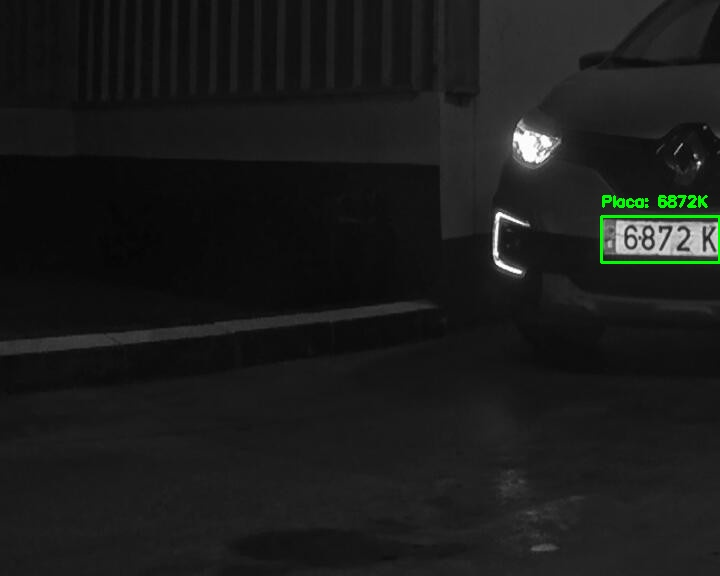

In [5]:
main(img_path="/content/drive/MyDrive/PROYECTO/ENTRADAS/1.jpg")

In [6]:
# Directorio que contiene las imágenes
image_directory = '/content/drive/My Drive/PROYECTO/ENTRADAS'

# Obtener una lista de todas las imágenes en el directorio
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Procesar cada imagen
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    print(f"Procesando: {image_file}")
    main(image_path)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
main(vid_path="/content/drive/MyDrive/PROYECTO/ENTRADAS/1.mp4",
     vid_out="/content/drive/MyDrive/PROYECTO/SALIDA/video_procesado.mp4")

[INFO] Loading models... 
[INFO] Working with video: /content/drive/MyDrive/PROYECTO/ENTRADAS/1.mp4


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[1, 3], [67, 3], [67, 20], [1, 20]], '[CLE455: 82', 0.21229215729584147)]
Tipo de vehículo: car, Placa: CLE45582, Confianza: 0.85
[([[3, 0], [68, 0], [68, 20], [3, 20]], 'CA 455.82', 0.47034269824227726)]
Tipo de vehículo: car, Placa: CA45582, Confianza: 0.85
[([[0, 0], [70, 0], [70, 20], [0, 20]], 'M55.02', 0.19439960411847076)]
Tipo de vehículo: car, Placa: M5502, Confianza: 0.85
[([[3, 3], [71, 3], [71, 20], [3, 20]], 'CA 455. 82', 0.43764910294405684)]
Tipo de vehículo: car, Placa: CA45582, Confianza: 0.82


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[2, 0], [74, 0], [74, 21], [2, 21]], 'C 455.82', 0.49023053314090476)]
Tipo de vehículo: car, Placa: C45582, Confianza: 0.83
[([[1, 3], [77, 3], [77, 21], [1, 21]], '[CLE5 :822', 0.1972721284565136)]
Tipo de vehículo: car, Placa: CLE5822, Confianza: 0.83
[([[0, 1], [78, 1], [78, 20], [0, 20]], 'Ia 455.822', 0.2677173321413579)]
Tipo de vehículo: car, Placa: IA455822, Confianza: 0.83
[([[0, 0], [81, 0], [81, 21], [0, 21]], '[CHE5 822', 0.11201366860089751)]
Tipo de vehículo: car, Placa: CHE5822, Confianza: 0.80
[([[0, 0], [82, 0], [82, 21], [0, 21]], '[CA55 822', 0.2337368519121233)]
Tipo de vehículo: car, Placa: CA55822, Confianza: 0.77


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[0, 0], [82, 0], [82, 22], [0, 22]], '[CA755 822', 0.11405046062504184)]
Tipo de vehículo: car, Placa: CA755822, Confianza: 0.76
[([[0, 0], [82, 0], [82, 21], [0, 21]], '[HE 822', 0.127177243746952)]
Tipo de vehículo: car, Placa: HE822, Confianza: 0.79
[([[0, 0], [83, 0], [83, 21], [0, 21]], '[CAE5 822', 0.23208632307714847)]
Tipo de vehículo: car, Placa: CAE5822, Confianza: 0.79
[([[0, 0], [82, 0], [82, 22], [0, 22]], '[CE5 822', 0.4185059020406892)]
Tipo de vehículo: car, Placa: CE5822, Confianza: 0.80
[([[0, 0], [84, 0], [84, 22], [0, 22]], 'Ia 455.822', 0.20151866781225455)]
Tipo de vehículo: car, Placa: IA455822, Confianza: 0.79
[([[2, 0], [86, 0], [86, 22], [2, 22]], 'CLE5 822', 0.17694485516987127)]
Tipo de vehículo: car, Placa: CLE5822, Confianza: 0.78


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[([[0, 0], [86, 0], [86, 22], [0, 22]], '[CH455 822', 0.1683010357007593)]
Tipo de vehículo: car, Placa: CH455822, Confianza: 0.79
[([[0, 0], [86, 0], [86, 21], [0, 21]], '[CA455 822', 0.21219978313289722)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.78
[([[0, 0], [86, 0], [86, 22], [0, 22]], '(CA 455.822', 0.13080386282307357)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.79
[([[0, 0], [84, 0], [84, 22], [0, 22]], 'ICA 455.822', 0.11545768706926522)]
Tipo de vehículo: car, Placa: ICA455822, Confianza: 0.81
[([[2, 0], [86, 0], [86, 22], [2, 22]], 'CA 455.822', 0.3453613226523502)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.81
[([[2, 0], [85, 0], [85, 21], [2, 21]], 'CA 455 022', 0.29017738447495633)]
Tipo de vehículo: car, Placa: CA455022, Confianza: 0.78


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[0, 0], [88, 0], [88, 22], [0, 22]], 'Ia 455.822', 0.2783963262008085)]
Tipo de vehículo: car, Placa: IA455822, Confianza: 0.78
[([[2, 0], [86, 0], [86, 23], [2, 23]], 'CA 455 822', 0.280283773642657)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.77
[([[0, 0], [88, 0], [88, 24], [0, 24]], '[CAE5 822', 0.151515708982605)]
Tipo de vehículo: car, Placa: CAE5822, Confianza: 0.78
[([[0, 0], [90, 0], [90, 22], [0, 22]], '(Ca 455.822', 0.1934067516037072)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.80
[([[0, 0], [88, 0], [88, 23], [0, 23]], 'CA 455 122', 0.26406408580194535)]
Tipo de vehículo: car, Placa: CA455122, Confianza: 0.79
[([[0, 0], [92, 0], [92, 23], [0, 23]], '[C 4E5 822', 0.12854842710356934)]
Tipo de vehículo: car, Placa: C4E5822, Confianza: 0.79


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[([[0, 0], [92, 0], [92, 24], [0, 24]], '[CA 455.822', 0.23625582953871235)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.81
[([[0, 0], [92, 0], [92, 25], [0, 25]], '(CA 55 822', 0.1506531742964802)]
Tipo de vehículo: car, Placa: CA55822, Confianza: 0.82
[([[0, 0], [92, 0], [92, 25], [0, 25]], '[CA E5 022', 0.06805433690329113)]
Tipo de vehículo: car, Placa: CAE5022, Confianza: 0.82
[([[0, 0], [94, 0], [94, 25], [0, 25]], '[CA 455 822', 0.19383124419979503)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.82
[([[0, 0], [90, 0], [90, 25], [0, 25]], '[CA455 822', 0.29322962804971825)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.79


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[0, 0], [93, 0], [93, 24], [0, 24]], 'Ta 455. 822', 0.27402665924682384)]
Tipo de vehículo: car, Placa: TA455822, Confianza: 0.77
[([[2, 0], [89, 0], [89, 25], [2, 25]], 'CA 455 822', 0.23440524494493115)]
Tipo de vehículo: car, Placa: CA455822, Confianza: 0.77
[([[0, 0], [90, 0], [90, 25], [0, 25]], 'ICA 455 827', 0.14941271073911805)]
Tipo de vehículo: car, Placa: ICA455827, Confianza: 0.77
[([[0, 0], [89, 0], [89, 25], [0, 25]], 'Ia 455 27', 0.16864387979853024)]
Tipo de vehículo: car, Placa: IA45527, Confianza: 0.76
[([[6, 0], [88, 0], [88, 25], [6, 25]], 'CA 455 82', 0.14664228490517398)]
Tipo de vehículo: car, Placa: CA45582, Confianza: 0.76
[([[0, 2], [86, 2], [86, 25], [0, 25]], '[CA 455:82', 0.060429355019619206)]
Tipo de vehículo: car, Placa: CA45582, Confianza: 0.74


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[0, 2], [85, 2], [85, 26], [0, 26]], 'IC4502', 0.04913811848755789)]
Tipo de vehículo: car, Placa: IC4502, Confianza: 0.76
[([[6, 2], [64, 2], [64, 27], [6, 27]], 'CE', 0.18739718384273832)]
Tipo de vehículo: car, Placa: CE, Confianza: 0.79
[([[0, 2], [80, 2], [80, 26], [0, 26]], 'IA 455 €', 0.09433096419755405)]
Tipo de vehículo: car, Placa: IA455, Confianza: 0.82
[([[0, 2], [80, 2], [80, 26], [0, 26]], 'IA 455-8', 0.12453801959041907)]
Tipo de vehículo: car, Placa: IA4558, Confianza: 0.82
[([[0, 2], [66, 2], [66, 25], [0, 25]], 'Ta 455', 0.3765131521221323)]
Tipo de vehículo: car, Placa: TA455, Confianza: 0.84


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[([[0, 2], [66, 2], [66, 26], [0, 26]], 'TCA 455', 0.21425548634435346)]
Tipo de vehículo: car, Placa: TCA455, Confianza: 0.85
[([[0, 2], [66, 2], [66, 25], [0, 25]], 'Tca 455', 0.20160150542619895)]
Tipo de vehículo: car, Placa: TCA455, Confianza: 0.86
[([[6, 2], [66, 2], [66, 26], [6, 26]], 'CA 455', 0.13318541467134798)]
Tipo de vehículo: car, Placa: CA455, Confianza: 0.86
[([[0, 2], [66, 2], [66, 25], [0, 25]], 'Tca 455', 0.29907170407176786)]
Tipo de vehículo: car, Placa: TCA455, Confianza: 0.86
[([[0, 2], [66, 2], [66, 26], [0, 26]], '(CA E5', 0.2113748109793177)]
Tipo de vehículo: car, Placa: CAE5, Confianza: 0.85
[([[6, 2], [68, 2], [68, 26], [6, 26]], 'CA 55', 0.11316345381225136)]
Tipo de vehículo: car, Placa: CA55, Confianza: 0.86


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[0, 0], [66, 0], [66, 26], [0, 26]], 'IcA 455', 0.17535091019165677)]
Tipo de vehículo: car, Placa: ICA455, Confianza: 0.86
[([[0, 2], [64, 2], [64, 26], [0, 26]], '(ca 455', 0.18857344592306705)]
Tipo de vehículo: car, Placa: CA455, Confianza: 0.85
[([[6, 2], [63, 2], [63, 26], [6, 26]], 'Ch', 0.33655428168224527)]
Tipo de vehículo: car, Placa: CH, Confianza: 0.83
[([[0, 2], [60, 2], [60, 25], [0, 25]], 'TA 45=', 0.17114541868396319)]
Tipo de vehículo: car, Placa: TA45, Confianza: 0.84
[([[0, 2], [32, 2], [32, 26], [0, 26]], 'IC', 0.1599670521032584)]
Tipo de vehículo: car, Placa: IC, Confianza: 0.85
[([[0, 4], [34, 4], [34, 26], [0, 26]], 'ICA', 0.3409229572640603)]
Tipo de vehículo: car, Placa: ICA, Confianza: 0.86


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[([[8, 4], [34, 4], [34, 27], [8, 27]], 'CA', 0.9604129965932015)]
Tipo de vehículo: car, Placa: CA, Confianza: 0.86
[([[8, 4], [34, 4], [34, 28], [8, 28]], 'CA', 0.8723372076967267)]
Tipo de vehículo: car, Placa: CA, Confianza: 0.86
[([[8, 2], [34, 2], [34, 27], [8, 27]], 'C', 0.9935504813422682)]
Tipo de vehículo: car, Placa: C, Confianza: 0.86
[([[6, 4], [34, 4], [34, 29], [6, 29]], 'C', 0.9793581851861042)]
Tipo de vehículo: car, Placa: C, Confianza: 0.86
[([[0, 4], [36, 4], [36, 28], [0, 28]], 'IC', 0.23156401036903404)]
Tipo de vehículo: car, Placa: IC, Confianza: 0.84
[([[8, 4], [36, 4], [36, 29], [8, 29]], 'C', 0.9959401650605493)]
Tipo de vehículo: car, Placa: C, Confianza: 0.82


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[([[6, 4], [36, 4], [36, 27], [6, 27]], 'CCA', 0.24488623158643696)]
Tipo de vehículo: car, Placa: CCA, Confianza: 0.80
[]
Tipo de vehículo: car, Placa: , Confianza: 0.84
[]
Tipo de vehículo: car, Placa: , Confianza: 0.85
[]
Tipo de vehículo: car, Placa: , Confianza: 0.85
[]
Tipo de vehículo: car, Placa: , Confianza: 0.84
[]
Tipo de vehículo: car, Placa: , Confianza: 0.84
[]
Tipo de vehículo: car, Placa: , Confianza: 0.83


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

[]
Tipo de vehículo: car, Placa: , Confianza: 0.78
[]
Tipo de vehículo: car, Placa: , Confianza: 0.74
[]
Tipo de vehículo: car, Placa: , Confianza: 0.73
[]
Tipo de vehículo: car, Placa: , Confianza: 0.69
[]
Tipo de vehículo: car, Placa: , Confianza: 0.60


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

Processed 100 frames


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

Processed 200 frames
[]
Tipo de vehículo: car, Placa: , Confianza: 0.58
[]
Tipo de vehículo: car, Placa: , Confianza: 0.59


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[]
Tipo de vehículo: car, Placa: , Confianza: 0.74
[]
Tipo de vehículo: car, Placa: , Confianza: 0.72
[]
Tipo de vehículo: car, Placa: , Confianza: 0.74


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

Processed 300 frames


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.au

Processed 400 frames


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto

[INFO] Video processing complete. Processed 497 frames.


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.auto